In [363]:
import numpy as np
import pandas as pd
import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from time import time
from datetime import datetime
from tqdm import tqdm, tqdm_notebook
from datetime import datetime

In [2]:
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [4]:
from keras.models import Input, Model
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Reshape, Concatenate, Bidirectional
from keras import backend as K

In [5]:
#Retrieves the import filepath.
def CreatePathName(dir1='', dir2='', dir3='', dir4='', filename=''):
    '''Directory generator function.

    Args:
        dir1: Parent direrctory name if exists.
        dir2: First Child direrctory name if exists.
        dir3: Second Child direrctory name if exists.
        dir4: Third Child direrctory name if exists.
        filename: Filname  if exists with the extension.

    Returns:
        Absolute path.
    '''
    path = os.path.join(os.path.dirname(os.path.realpath(__name__)), dir1, dir2, dir3, dir4, filename)
    return path

In [6]:
#Joins filepath with filename and changes the working directory.
csvFilesPath = CreatePathName(os.pardir, 'input')
os.chdir(csvFilesPath)
print(os.getcwd())

C:\DATA\DATA\ANN_python\Projects_to_Investigate\HEC\input


In [7]:
#Printing first 2 and last row of df.
dfAEP = (pd.read_csv(filepath_or_buffer=os.listdir(csvFilesPath)[0], 
                                     index_col=0, 
                                     header=0, 
                                     parse_dates=True)).sort_index()
print("Dataframe {} \n {} \n\n has {} rows.".format("dfAEP", dfAEP.iloc[[0,1,-1]], dfAEP.shape[0]))

Dataframe dfAEP 
                       AEP_MW
Datetime                    
2004-10-01 01:00:00  12379.0
2004-10-01 02:00:00  11935.0
2018-08-03 00:00:00  14809.0 

 has 121273 rows.


Let's rename the AEP_MW column "Cons".

In [8]:
#Rename the column of all dfs to Cons.
dfAEP.rename(columns=lambda x: 'Cons', inplace=True)

In [9]:
def checkNegativeOrZeroValues (df, column):
    '''
    Descriptioin:
        Prints the number of zero or negative values, and returns the index of such row in case of non-zero result.
        If no zero value, returns nothing.
        
    Args:
        df: Data Frame to look in.
        column: the column in which the 0 or negative value is checked. 
    
    Returns:
        list of 0 indices in df. 
        
    Revisions:
        E.Khachatryan 2020-06-06
    '''
    indicesOfZeros = []
    noOfZeros = len(df.loc[df[column]<=0, column].values.tolist())
    if noOfZeros==0:
        return print("There is no 0 or negative value in the df")
    elif noOfZeros>0:
        print("There are '{}' negative or zero values in the df".format(noOfZeros))
        indicesOfZeros = df.index[df[column] <= 0].values.tolist()
        return indicesOfZeros
    else:
        raise Exception("Number of rows couldn't be negative: {}".format(noOfZeros))
         
########################################################################################
def checkMissingValues(df):
    '''
    Descriptioin:
        Prints the number of missing (null) values, and returns the index of such row in case of non-zero result.
        If no zero value, returns nothing.
        
    Args:
        df: Data Frame to look in.
            
    Returns:
        list of 0 indices in df. 
        
    Revisions:
        E.Khachatryan 2020-06-07   
    '''
    nullRows = df.isnull().any(axis=1)
    sumOfNullContainingRows = sum(nullRows)
    if sumOfNullContainingRows == 0:
        print("Data Frame has no missing values.")
    else:
        print("Data Frame has {} missing value(s).".format(sumOfNullContainingRows))
        return df[nullRows].index.values

In [10]:
checkNegativeOrZeroValues(dfAEP, 'Cons')
checkMissingValues(dfAEP)

There is no 0 or negative value in the df
Data Frame has no missing values.


In [11]:
def CreatePlotTotalConsumption (df, y_col, chart_title, x_label, y_label):
    '''
    DESCRIPTION:
        Create a plot for total consumption.

    Args:
        df: Data Frame.
        y_col: Y axes
        x_col: X axes

    Returns:
        A list of Line2D objects representing the plotted data.
    '''

    # Create a plot.
    sns.set()
    df.iloc[0:df.shape[0],:].plot(y = y_col, use_index=True, figsize = (18,6), linewidth=1)

    # Add labels.
    plt.xlabel(x_label)
    plt.ylabel(y_label, fontsize = 12)

    # Add a title.
    chart_title = chart_title
    plt.title(chart_title)
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

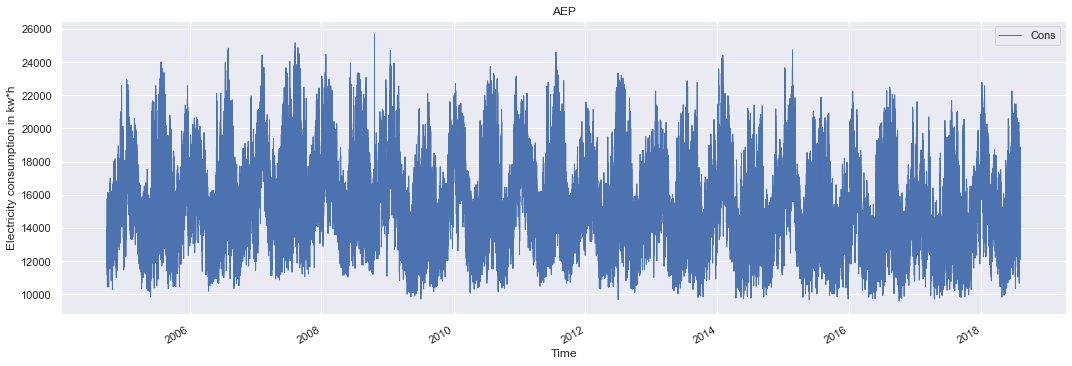

In [12]:
CreatePlotTotalConsumption(df=dfAEP, y_col='Cons', chart_title="AEP", 
                               x_label='Time', y_label='Electricity consumption in kw*h')

### Feature engineering
#### Predictor Variable

In [13]:
#Adding day of week and day of week and hour.
# def getWeekDay(timestamp):
#     weekday = timestamp.weekday()
#     return weekday

def addHoursToWDays(timestamp):
    weekdayHour = str(timestamp.weekday()) + '_' + timestamp.strftime("%H")
    return weekdayHour

In [14]:
weekDayHour = []
for i in range(dfAEP.shape[0]):
    weekDayHour.append(addHoursToWDays(dfAEP.index[i]))
dfAEP['WeekDayHour'] = weekDayHour
print(dfAEP.head())

                        Cons WeekDayHour
Datetime                                
2004-10-01 01:00:00  12379.0        4_01
2004-10-01 02:00:00  11935.0        4_02
2004-10-01 03:00:00  11692.0        4_03
2004-10-01 04:00:00  11597.0        4_04
2004-10-01 05:00:00  11681.0        4_05


In [15]:
#Defining the function to add the average consumption based on weekday+hour combination.
def addAvgConsUsingWeekdayHour(dataFrame, grByCriteriaCol, sourceCol, targetCol, RowsToCount, roundLevel=1):
    if (grByCriteriaCol == sourceCol or grByCriteriaCol==targetCol):
        raise Exception('Group by Criteria Column cannot be the same as Source Column or Target Column.')
    dataFrame[targetCol] = dataFrame.loc[:,grByCriteriaCol]\
                                            .replace(dataFrame.iloc[:RowsToCount,:]\
                                                     .groupby(grByCriteriaCol)[sourceCol]\
                                                         .mean()\
                                                             .round(roundLevel)\
                                                                 .to_dict())

#Adding meanCons column that contains the average consumption by weekday and hour.    
Rows = 24*365
addAvgConsUsingWeekdayHour(dfAEP, 'WeekDayHour', 'Cons', 'meanCons', Rows)
print(dfAEP.head())

                        Cons WeekDayHour  meanCons
Datetime                                          
2004-10-01 01:00:00  12379.0        4_01   14338.4
2004-10-01 02:00:00  11935.0        4_02   13787.9
2004-10-01 03:00:00  11692.0        4_03   13486.3
2004-10-01 04:00:00  11597.0        4_04   13369.5
2004-10-01 05:00:00  11681.0        4_05   13513.9


In [17]:
#Creating a function to standardize the target column.
def addStandardizedColumn(dataFrame, sourceCol, meanCol, targetCol):
    dataFrame[targetCol] = (np.log(dataFrame.loc[:, sourceCol]) - np.log(dataFrame.loc[:, meanCol]))
    
addStandardizedColumn(dfAEP, 'Cons', 'meanCons', 'logdiffConsAndMeanCons')

(dfAEP.head())

,Cons,WeekDayHour,meanCons,logdiffConsAndMeanCons
Datetime,,,,
2004-10-01 01:00:00,12379.0,4_01,14338.4,-0.146940
2004-10-01 02:00:00,11935.0,4_02,13787.9,-0.144316
2004-10-01 03:00:00,11692.0,4_03,13486.3,-0.142770
2004-10-01 04:00:00,11597.0,4_04,13369.5,-0.142230
2004-10-01 05:00:00,11681.0,4_05,13513.9,-0.145755


In [19]:
#########################

In [20]:
def reverseStandardizedColumn(dataFrame, sourceCol, meanCol, targetCol):
    #dataFrame[targetCol] = np.exp((dataFrame.loc[:, sourceCol]) + np.log(dataFrame.loc[:, meanCol]))
    dataFrame[targetCol] = np.exp((dataFrame.loc[:, sourceCol]) + np.log(dataFrame.loc[:, meanCol]))
    
reverseStandardizedColumn(dataFrame=dfAEP, sourceCol='logdiffConsAndMeanCons', meanCol='meanCons', targetCol='reversed')
dfAEP.head()

,Cons,WeekDayHour,meanCons,logdiffConsAndMeanCons,reversed
Datetime,,,,,
2004-10-01 01:00:00,12379.0,4_01,14338.4,-0.146940,12379.0
2004-10-01 02:00:00,11935.0,4_02,13787.9,-0.144316,11935.0
2004-10-01 03:00:00,11692.0,4_03,13486.3,-0.142770,11692.0
2004-10-01 04:00:00,11597.0,4_04,13369.5,-0.142230,11597.0
2004-10-01 05:00:00,11681.0,4_05,13513.9,-0.145755,11681.0


In [24]:
##################

In [25]:
#TODO: add param for range(0, numElements-totalSeqLen+1, 1). 1 should be configurable.

def generateMultiStepModelInput(dataFrame, totalSeqLen, ySeqLen, col):
    '''
    Generates X and Y sets from dataframe's column.
    
    Args:
        dataFrame: Data Frame to look at.
        totalSeqLen: The predictor and response variables sequence length combined.
        ySeqLen: The response variable sequence lengt.
        col: The column to look at.
        
    Returns:
        2 lists: 1st X list with the dimensions of: ((df total rows-totalSeqLen+1), 
                                                            totalSeqLen-ySeqLen, 
                                                            1)
                 2nd Y list with the dimensions of: ((df total rows-totalSeqLen+1),
                                                        ySeqLen)

    Revision:
        June 06, 2020 created (Edgar Khachatryan)
    '''
    dataMatrix = dataFrame[col]
    numElements = dataMatrix.shape[0]
    
    indices = dataFrame.index.values

    for _, stop in zip(range(0, numElements-totalSeqLen+1, 1), 
                       range(totalSeqLen, numElements+1, 1)):
        
        yield dataMatrix[(stop-totalSeqLen):stop-ySeqLen].values.reshape((-1,len(col))), \
              dataMatrix[stop-ySeqLen:stop].values.reshape((-1))

#Getting the indices.
def getIndexOfY(dataFrame, totalSeqLen, ySeqLen):
    pass

In [26]:
sequenceLength = 7*24
dfAEP.index[sequenceLength]

Timestamp('2004-10-08 01:00:00')

In [29]:
X, Y = [], []
totalSequenceLength = 5*7*24 #Total 5 weeks,use 4 weeks data to forecast 1 week foreward.
ySequenceLength = 7*24


for i in generateMultiStepModelInput(dfAEP, totalSequenceLength, ySequenceLength, ['logdiffConsAndMeanCons']):
    x, y = i
    X.append(x)
    Y.append(y)
X = np.asarray(X)
Y = np.asarray(Y)

In [30]:
print(X.shape, Y.shape)

(120434, 672, 1) (120434, 168)


In [31]:
losses = [lambda y,f: K.mean(K.maximum(0.1*(y-f), (0.1-1)*(y-f)), axis=-1), 
         lambda y,f: K.mean(K.maximum(0.5*(y-f), (0.5-1)*(y-f)), axis=-1), 
         lambda y,f: K.mean(K.maximum(0.9*(y-f), (0.9-1)*(y-f)), axis=-1)]

# SECOND version.

In [ ]:
#Model uses 4 weeks of data (672 hours) to predict next 7 days (168 hours) of consumption.

In [55]:
trainLength = 168*52
X_Train, y_Train = X[0:trainLength], Y[0:trainLength]

In [47]:
X_Test, y_Test = X[trainLength:2*trainLength], Y[trainLength:2*trainLength]

In [451]:
print("The input shape of data is {}, {} and {}. \nThe output shape is {}, {}.".format(X_Train.shape[0], X_Train.shape[1], X_Train.shape[2],  y_Train.shape[0], y_Train.shape[1]))

The input shape of data is 8736, 672 and 1. 
The output shape is 8736, 168.


In [43]:
inputs = Input(shape=(X_Train.shape[1], X_Train.shape[2]))
lstm = Bidirectional(LSTM(32, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)

dense = Dense(50)(lstm)

out10 = Dense(y_Train.shape[1])(dense)
out50 = Dense(y_Train.shape[1])(dense)
out90 = Dense(y_Train.shape[1])(dense)

model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 672, 1)       0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 672, 64)      8704        input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 32)           10368       bidirectional_3[0][0]            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 50)           1650        bidirectional_4[0][0]            
__________________________________________________________________________________________________
dense_6 (D

In [ ]:
#Train model or load pretrained model for 30 epochs(4.3 hours training.)

In [44]:
history = model.fit(X_Train, [y_Train, y_Train, y_Train], epochs=30, batch_size=548, verbose=2, shuffle=True)

Epoch 1/30
 - 248s - loss: 0.0398 - dense_6_loss: 0.0437 - dense_7_loss: 0.0481 - dense_8_loss: 0.0408
Epoch 2/30
 - 305s - loss: 0.0282 - dense_6_loss: 0.0241 - dense_7_loss: 0.0450 - dense_8_loss: 0.0249
Epoch 3/30
 - 282s - loss: 0.0228 - dense_6_loss: 0.0167 - dense_7_loss: 0.0396 - dense_8_loss: 0.0197
Epoch 4/30
 - 316s - loss: 0.0217 - dense_6_loss: 0.0154 - dense_7_loss: 0.0385 - dense_8_loss: 0.0186
Epoch 5/30
 - 288s - loss: 0.0214 - dense_6_loss: 0.0150 - dense_7_loss: 0.0380 - dense_8_loss: 0.0182
Epoch 6/30
 - 350s - loss: 0.0213 - dense_6_loss: 0.0149 - dense_7_loss: 0.0379 - dense_8_loss: 0.0182
Epoch 7/30
 - 338s - loss: 0.0213 - dense_6_loss: 0.0149 - dense_7_loss: 0.0379 - dense_8_loss: 0.0181
Epoch 8/30
 - 342s - loss: 0.0212 - dense_6_loss: 0.0148 - dense_7_loss: 0.0376 - dense_8_loss: 0.0181
Epoch 9/30
 - 366s - loss: 0.0212 - dense_6_loss: 0.0149 - dense_7_loss: 0.0376 - dense_8_loss: 0.0180
Epoch 10/30
 - 366s - loss: 0.0211 - dense_6_loss: 0.0148 - dense_7_loss:

In [439]:
# Change working directory to ../Models.
modelPath = CreatePathName(os.pardir, 'Models')
os.chdir(modelPath)
print(os.getcwd())

C:\DATA\DATA\ANN_python\Projects_to_Investigate\HEC\Models


In [442]:
# Load model from .json file.
LSTMModelFile = open("LSTMModel.json", "r")
modelReader = LSTMModelFile.read()
LSTMModelFile.close()
model = model_from_json(modelReader)

# Load weights to the loadedModel from .hdf5 file
model.load_weights("LSTMModelWeights.h5")

In [440]:
# # Save model to .json format.
# modelSaveJson = model.to_json()
# with open("LSTMModel.json", "w") as json:
#     json.write(modelSaveJson)

# # Save weights to HDF5
# model.save_weights("LSTMModelWeights.h5")

In [74]:
###LOADED MODEL QUANTILEs BOOTSTRAPPING ###
#1 prediction.
yHat10, yHat, yHat90 = [], [], []
NN = K.function([model.layers[0].input, K.learning_phase()], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in tqdm_notebook(range(0,100)):
    predd = NN([X_Test[0:100], 0.5])
    yHat10.append(predd[0])
    yHat.append(predd[1])
    yHat90.append(predd[2])
    
yHat10 = np.quantile(yHat10, 0.1, axis=0)
yHat = np.asarray(yHat).mean(axis=0)
yHat90 = np.quantile(yHat90, 0.9, axis=0)

In [268]:
def reverseStandardizedValue(YTestRowIndex, YTestColIndex, 
                             XTrainShape0, XTrainShape1,
                             sourceDF, meanCol, souceVal):
    '''
    YTestRowIndex, YTestColIndex: Index of row and column, by 1 less than XTrainShape0, XTrainShape1.
    '''
    meanVal = sourceDF.loc[ sourceDF.index[ YTestRowIndex + YTestColIndex
                                           + XTrainShape0 + XTrainShape1 ],
                            meanCol ]
    
    return np.exp(souceVal + np.log(meanVal))

def returnRowIndex(YTestRowIndex, YTestColIndex, 
                   XTrainShape0, XTrainShape1,
                   sourceDF):
    index = sourceDF.index[ YTestRowIndex + YTestColIndex
                          + XTrainShape0 + XTrainShape1 
                          ]
    return index

# Returns row index from df.
# for i in range(Y.shape[0]):
#     for j in range(Y.shape[1]):
#         print(returnRowIndex(i, j, X.shape[1], dfAEP))

# Returns row index from df.
# for i in range(Y.shape[0]):
#     for j in range(Y.shape[1]):
#         print(reverseStandardizedValue(i, j, X.shape[1], dfAEP, 'meanCons', Y[i,j]))

In [337]:
#yHat
reverseStandardizedValue(0, 
                         100, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfAEP, 
                         'meanCons', 
                         yHat[0][100])

16782.252693412447

In [338]:
reverseStandardizedValue(0, 
                         100, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfAEP, 
                         'meanCons', 
                         y_Test[0][100])

16550.000000000004

In [311]:
predictions = []
for i in range(1):
    for j in range(yHat.shape[1]):
        predictions.append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfAEP, 
                         'meanCons', 
                         yHat[i][j]))
predictions = np.asarray(predictions)

In [312]:
actual = []
for i in range(1):
    for j in range(y_Test.shape[1]):
        actual.append(reverseStandardizedValue(i, 
                         j, 
                         X_Train.shape[0], 
                         X_Train.shape[1],  
                         dfAEP, 
                         'meanCons', 
                         y_Test[i][j]))
actual = np.asarray(actual)

In [346]:
# Retriveing the actual consumption data for the predicted period from dataframe.
predStartIndex = returnRowIndex(0, 0, X_Train.shape[0], X_Train.shape[1], dfAEP)
predEndIndex = returnRowIndex(yHat.shape[0]-1, yHat.shape[1]-1, X_Train.shape[0], X_Train.shape[1], dfAEP)
actual = dfAEP.loc[predStartIndex:predEndIndex, 'Cons'].values

In [ ]:
#############PLotting experiment

In [365]:
import matplotlib.pyplot as plt

In [417]:
#t = np.asarray([returnRowIndex(0, k, X_Train.shape[0], X_Train.shape[1], dfAEP) for k in range(yHat.shape[1])])
#alternative t
t = np.linspace(0,200)
x = np.asarray([reverseStandardizedValue(0, k, X_Train.shape[0], X_Train.shape[1], dfAEP, 'meanCons', yHat[0][k]) for k in range(yHat.shape[1])])

In [414]:
x.shape

(168,)

In [415]:
f = lambda x: x * x

[0, 168]

In [ ]:
def f(x):
    return x * x

In [430]:
def l,(i):
    l.set_data(t[:i], x[:i])
    return l

SyntaxError: invalid syntax (<ipython-input-430-080720c1d983>, line 1)

<IPython.core.display.Javascript object>


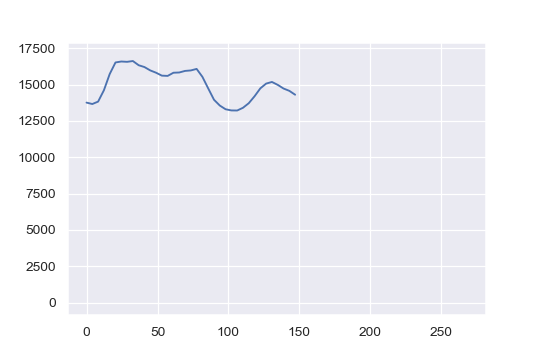

In [445]:
%matplotlib notebook
import matplotlib.animation

# t = np.linspace(0,2*np.pi)
# x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0, 268],[0, 17000])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

plt.show()

In [423]:
########

In [448]:
# %matplotlib notebook
# from datetime import datetime
# from matplotlib import pyplot
# from matplotlib.animation import FuncAnimation
# from random import randrange

# x_data, y_data = [], []

# figure = pyplot.figure()
# line, = pyplot.plot_date(x_data, y_data, '-')
# #x_data = [reverseStandardizedValue(0, k, X_Train.shape[0], X_Train.shape[1], 
# #                                         dfAEP, 'meanCons', yHat[0][k]) for k in range(yHat.shape[1])]

# def update(frame):
#     x_data.append(datetime.now())
#     y_data.append(randrange(0, 100))
#     line.set_data(x_data, y_data)
#     figure.gca().relim()
#     figure.gca().autoscale_view()
#     return line,

# animation = FuncAnimation(figure, update, interval=200)

# pyplot.show()

In [ ]:
################

In [449]:
# # Plotting the actual and predicted values.
# plt.figure(figsize=(20,10))
# plt.plot(actual, color='red', alpha=0.4, label="Actual")
# plt.plot(predictions, color='blue', alpha=0.4, label="Prediction")
# #plt.fill_between(x_axis, pred_50_m-lower_coridor, pred_50_m + upper_coridor, alpha=0.2, 
# #                 edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=1, linestyle='dashdot', antialiased=True)

# plt.xlabel('Hours')
# plt.ylabel('Station level consumption in cubic meters (m3)')
# plt.title('LSTM prediction for 133 days')
# #plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m)
# plt.axis([-5, max(actual.shape[0], predictions.shape[0])+5, 0, 18000])
# plt.grid(True)

In [ ]:
# ### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###

# plt.figure(figsize=(16,12))
# plt.plot(np.exp(y_test1+init[364:]), color='red', alpha=0.4, label="Actual")
# plt.plot(pred_50_m, color='blue', alpha=0.4, label="Prediction")
# plt.fill_between(x_axis, pred_50_m-lower_coridor, pred_50_m + upper_coridor, alpha=0.2, 
#                  edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=1, linestyle='dashdot', antialiased=True)

# plt.xlabel('Days')
# plt.ylabel('Station level consumption in cubic meters (m3)')
# plt.title('LSTM prediction for 133 days')
# plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m)
# plt.axis([-5, 140, 0, 7000])
# plt.grid(True)

In [459]:
# #Getting the last value of X[0] from dataframe.
# print(dfAEP.index[X.shape[1]-1], dfAEP.loc[dfAEP.index[X.shape[1]-1],'logdiffConsAndMeanCons'])
# print(X[0][-1])

# #Getting the first value of Y[0][0] from dataframe.
# print(dfAEP.index[X.shape[1]], dfAEP.loc[dfAEP.index[X.shape[1]],'logdiffConsAndMeanCons'])
# print(Y[0][0])

# #Getting the last value of Y[0][-1] from dataframe.
# print(dfAEP.index[X.shape[1]+Y.shape[1]-1], dfAEP.loc[dfAEP.index[X.shape[1]+Y.shape[1]-1],'logdiffConsAndMeanCons'])
# print(Y[0][-1])

# #Getting the first value of Y[1] from dataframe.
# print(dfAEP.index[X.shape[1]+1], dfAEP.loc[dfAEP.index[X.shape[1]+1],'logdiffConsAndMeanCons'])
# #Getting the second row's first value from Y.
# print(Y[1][0])

# #Getting the meanConsumption from dataframe.
# print(dfAEP.index[X.shape[1]+1], dfAEP.loc[dfAEP.index[X.shape[1]+1], 'meanCons'])


# #Getting the first value of Y[120433][0] from dataframe.
# print(dfAEP.index[X.shape[1]+120433+167], dfAEP.loc[dfAEP.index[X.shape[1]+120433+167],'logdiffConsAndMeanCons'])
# #Getting the second row's first value from Y.
# print(Y[120433][167])

# #Getting the first value of Y[120433][0] from dataframe.
# print(dfAEP.index[X.shape[1]+0+2], dfAEP.loc[dfAEP.index[X.shape[1]+0+2],['logdiffConsAndMeanCons', 'Cons']])
# #Getting the second row's first value from Y.
# print(Y[120433][167])

# #Getting the first value of Y[0][0] from dataframe.
# print(dfAEP.index[X.shape[1]+0+1], dfAEP.loc[dfAEP.index[X.shape[1]+0+1],['logdiffConsAndMeanCons', 'Cons']])
# #Getting the second row's first value from Y.
# print(Y[0][0])

# SECOND VERSION END

In [206]:
from keras.callbacks import Callback as Callback

In [207]:
# updatable plot
# a minimal example (sort of)

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [72]:
print(X_train.shape, y_train.shape)

(8760, 168, 1) (8760, 168)


In [73]:
X_train.shape

(8760, 168, 1)

In [74]:
import csv
import numpy as np
fil_name = 'y_train'
example = y_train
example = example.tolist()
with open(fil_name+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(example)

#to read file you saved
with open(fil_name+'.csv', 'r') as f:
  reader = csv.reader(f)
  examples = list(reader)

print(examples)
nwexamples = []
for row in examples:
    nwrow = []
    for r in row:
        nwrow.append(eval(r))
    nwexamples.append(nwrow)
print(nwexamples)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [56]:
y_train.shape

(8760, 168)

In [67]:
11 % -10

-9

In [61]:
history = model.fit(X_train, [y_train, y_train, y_train], epochs=2, batch_size=2190, verbose=2, shuffle=True)

Epoch 1/2
 - 57s - loss: 0.0415 - dense_2_loss: 0.0466 - dense_3_loss: 0.0483 - dense_4_loss: 0.0436
Epoch 2/2
 - 60s - loss: 0.0390 - dense_2_loss: 0.0412 - dense_3_loss: 0.0478 - dense_4_loss: 0.0409


In [128]:
history = model.fit(X_train, [y_train, y_train, y_train], epochs=30, batch_size=2190, verbose=2, shuffle=True)

Epoch 1/30
 - 84s - loss: 0.0265 - dense_2_loss: 0.0173 - dense_3_loss: 0.0485 - dense_4_loss: 0.0226
Epoch 2/30
 - 111s - loss: 0.0265 - dense_2_loss: 0.0173 - dense_3_loss: 0.0484 - dense_4_loss: 0.0225
Epoch 3/30
 - 86s - loss: 0.0264 - dense_2_loss: 0.0172 - dense_3_loss: 0.0483 - dense_4_loss: 0.0225
Epoch 4/30
 - 89s - loss: 0.0264 - dense_2_loss: 0.0171 - dense_3_loss: 0.0483 - dense_4_loss: 0.0224
Epoch 5/30
 - 93s - loss: 0.0263 - dense_2_loss: 0.0171 - dense_3_loss: 0.0483 - dense_4_loss: 0.0224
Epoch 6/30
 - 97s - loss: 0.0263 - dense_2_loss: 0.0171 - dense_3_loss: 0.0483 - dense_4_loss: 0.0224
Epoch 7/30
 - 101s - loss: 0.0263 - dense_2_loss: 0.0171 - dense_3_loss: 0.0482 - dense_4_loss: 0.0224
Epoch 8/30
 - 106s - loss: 0.0263 - dense_2_loss: 0.0171 - dense_3_loss: 0.0482 - dense_4_loss: 0.0224
Epoch 9/30
 - 107s - loss: 0.0263 - dense_2_loss: 0.0171 - dense_3_loss: 0.0482 - dense_4_loss: 0.0224
Epoch 10/30
 - 111s - loss: 0.0263 - dense_2_loss: 0.0170 - dense_3_loss: 0.04

In [129]:
# # SAVE sequence_autoencoder model to JSON

# sequence_model_json = model.to_json()

# with open("sequence_model.json", "w") as json_file:
#     json_file.write(sequence_model_json)
# # serialize weights to HDF5
# model.save_weights("sequence_model_weights.h5")

In [64]:
# #Joins filepath with filename and changes the working directory.
# model_path = (CreatePathName(os.pardir, 'Models', filename='model.json'))
# model_weights_path = (CreatePathName(os.pardir, 'Models', filename='model_weights.h5'))

In [78]:
# #Load sequence_autoencoder json and create model

# model_read_file = open(model_path, 'r')
# loaded_model = model_read_file.read()
# model_read_file.close()
# loaded_model = model_from_json(loaded_model)
# # load weights into new model
# loaded_model.load_weights(model_weights_path)

In [130]:
X_test[0:8760].shape

(8760, 168, 1)

In [ ]:
### QUANTILEs BOOTSTRAPPING ###
# pred_10, pred_50, pred_90 = [], [], []
# NN = K.function([model.layers[0].input, K.learning_phase()], 
#                 [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

# for i in tqdm_notebook(range(0,10)):
#     predd = NN([X_test[0:8760], 0.5])
#     pred_10.append(predd[0])
#     pred_50.append(predd[1])
#     pred_90.append(predd[2])
    
# pred_10 = np.asarray(pred_10)[:,:,0] 
# pred_50 = np.asarray(pred_50)[:,:,0]
# pred_90 = np.asarray(pred_90)[:,:,0]

# ### REVERSE TRANSFORM PREDICTIONS ###
# pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + mean[364*24:364*24+8760])
# pred_50_m = np.exp(pred_50.mean(axis=0) + mean[364*24:364*24+8760])
# pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + mean[364*24:364*24+8760])

In [198]:
###LOADED MODEL QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model.layers[0].input, K.learning_phase()], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in tqdm_notebook(range(0,10)):
    predd = NN([X_test[0:1], 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

In [201]:
np.array(pred_10).shape

(10, 1, 168)

In [ ]:
#NOT NEEDED!
# pred_10 = np.asarray(pred_10)[:,:,0] 
# pred_50 = np.asarray(pred_50)[:,:,0]
# pred_90 = np.asarray(pred_90)[:,:,0]

In [141]:
#Converting consumption and mean consumption to 3D arrays and getting the logarithm of them. 
#TODO: make sure correct
df_mean = pd.DataFrame(mean, columns=['main'])

mean2d = []
for sequence in genResponse(df_mean, sequenceLength, ['main']):
    mean2d.append(sequence)
mean2d = np.array(response2d)

#################################

In [221]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90, 0.9, axis=0) + mean2d[0])
pred_50_m = np.exp(np.asarray(pred_50).mean(axis=0)  + mean2d[0])
pred_10_m = np.exp(np.quantile(pred_10, 0.1, axis=0) + mean2d[0])


In [234]:
#pred_50_m

In [233]:
#np.exp(y_test[0:1] + mean2d[0])

In [237]:
### EVALUATION METRIC ###
print(mean_squared_log_error(np.exp(y_test[0:1] + mean2d[0]), pred_50_m))

print(mean_squared_error(np.exp(y_test[0:1] + mean2d[0]), pred_50_m))

0.0005242604507332028
0.0016855583767169504


In [256]:
x_axis = np.linspace(0, y_test[0:1].shape[0], y_test[0:1].shape[1])
x_axis.shape

(168,)

In [247]:
#The sum of coridor
uncertantanity = pred_90_m - pred_10_m
upper_coridor = pred_90_m - pred_50_m
lower_coridor = pred_50_m - pred_10_m

In [250]:
np.exp(y_test[0:1] + mean2d[0]).flatten().shape

(168,)

In [253]:
pred_50_m.flatten().shape

(168,)

In [259]:
(pred_50_m.flatten() - lower_coridor).flatten()

array([0.72513941, 0.73387692, 0.71481055, 0.72981357, 0.73018642,
       0.75071031, 0.76393825, 0.77987139, 0.7639877 , 0.77280765,
       0.76833701, 0.75233438, 0.7551888 , 0.77455651, 0.75673944,
       0.75255781, 0.74666011, 0.728054  , 0.71720727, 0.74843064,
       0.7531333 , 0.7424764 , 0.72662318, 0.73659933, 0.72608225,
       0.7356398 , 0.7250043 , 0.7196357 , 0.72008785, 0.72325779,
       0.72227793, 0.73984194, 0.72928777, 0.73997893, 0.7395553 ,
       0.73268848, 0.73811918, 0.73471143, 0.73003871, 0.72506285,
       0.72398532, 0.72088674, 0.71592654, 0.73660879, 0.75670458,
       0.73403654, 0.72705626, 0.71650987, 0.70795343, 0.70559341,
       0.70984316, 0.71503928, 0.71101158, 0.71403441, 0.7179643 ,
       0.72241436, 0.71593393, 0.71421433, 0.730082  , 0.72849488,
       0.7231262 , 0.71880206, 0.72220617, 0.71558662, 0.70474756,
       0.69516611, 0.69811361, 0.73568846, 0.73469158, 0.7275655 ,
       0.71379954, 0.71246553, 0.72376706, 0.72505671, 0.73558

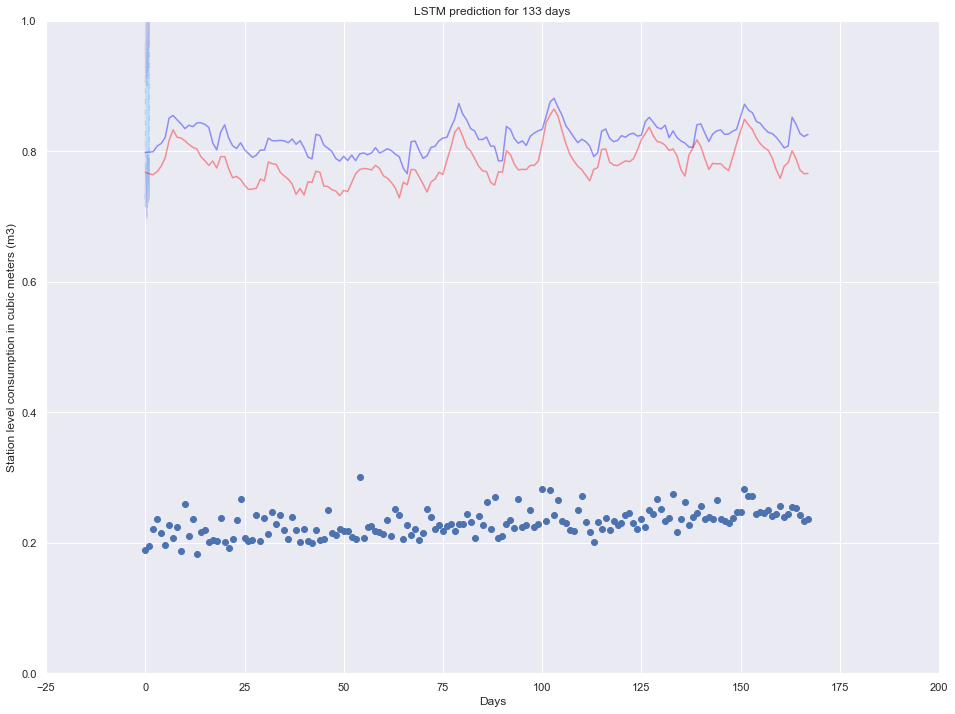

In [263]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###

plt.figure(figsize=(16,12))
plt.plot(np.exp(y_test[0:1] + mean2d[0]).flatten(), color='red', alpha=0.4, label="Actual")
plt.plot(pred_50_m.flatten(), color='blue', alpha=0.4, label="Prediction")
plt.fill_between(x_axis, (pred_50_m.flatten() - lower_coridor).flatten(), (pred_50_m.flatten() + upper_coridor).flatten(), alpha=0.2, 
                 edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=1, linestyle='dashdot', antialiased=True)

plt.xlabel('Days')
plt.ylabel('Station level consumption in cubic meters (m3)')
plt.title('LSTM prediction for 133 days')
plt.scatter(range(len(pred_10_m.flatten())), pred_90_m.flatten() - pred_10_m.flatten())
plt.axis([-25, 200, 0, 1])
plt.grid(True)

In [98]:
X_test[0:1].shape

(1, 168, 1)

In [112]:
K.function([loaded_model.layers[0].input, K.learning_phase()], 
                [loaded_model.layers[-3].output,loaded_model.layers[-2].output,loaded_model.layers[-1].output])

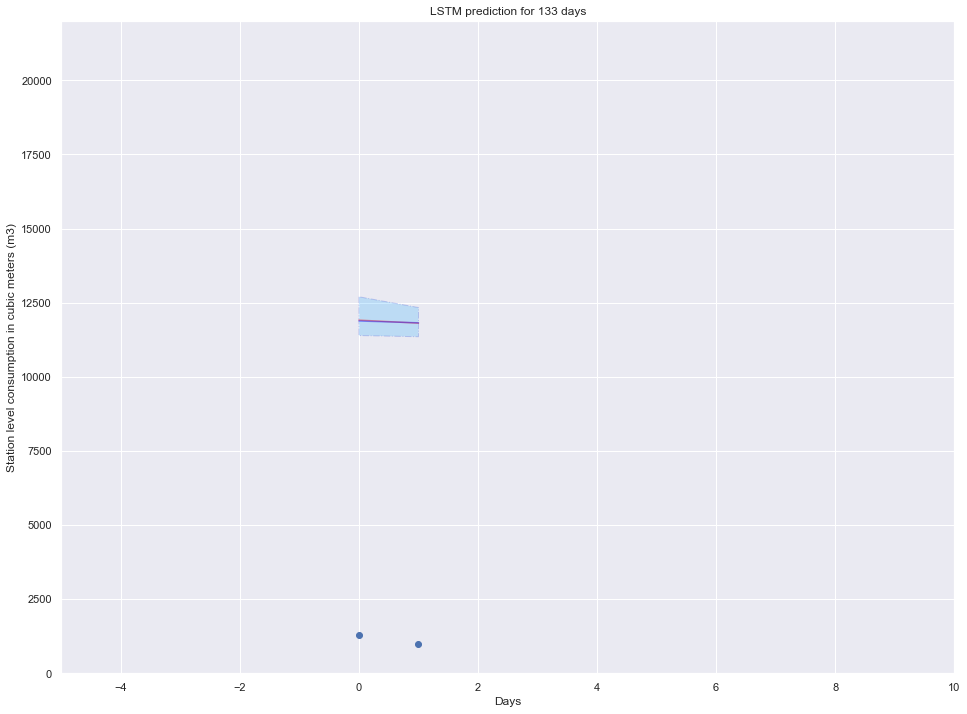

In [111]:
### PLOT 1 data point ###

pred_10, pred_50, pred_90 = [], [], []

NN = K.function([loaded_model.layers[0].input, K.learning_phase()], 
                [loaded_model.layers[-3].output,loaded_model.layers[-2].output,loaded_model.layers[-1].output])

for i in tqdm_notebook(range(0,10)):
    predd = NN([X_test[0:2], 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])
    
pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + mean[364*24:364*24+2])
pred_50_m = np.exp(pred_50.mean(axis=0)            + mean[364*24:364*24+2])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + mean[364*24:364*24+2])

x_axis = np.linspace(0, y_test[0:2].shape[0]-1, y_test[0:2].shape[0])
x_axis.shape

upper_coridor = pred_90_m - pred_50_m
lower_coridor = pred_50_m - pred_10_m

plt.figure(figsize=(16,12))
plt.plot(np.exp(y_test[0:1] + mean[364*24:364*24+2]), color='red', alpha=0.4, label="Actual")
plt.plot(pred_50_m, color='blue', alpha=0.4, label="Prediction")
plt.fill_between(x_axis, pred_50_m-lower_coridor, pred_50_m + upper_coridor, alpha=0.2, 
                 edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=1, linestyle='dashdot', antialiased=True)

plt.xlabel('Days')
plt.ylabel('Station level consumption in cubic meters (m3)')
plt.title('LSTM prediction for 133 days')
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m)
plt.axis([-5, 10, 0, 22000])
plt.grid(True)

In [135]:
loaded_model.predict(X_test[0:2], steps=5)[2]

array([[-0.03863142],
       [-0.09381885],
       [-0.04514868],
       [-0.09092932],
       [-0.06486496],
       [-0.09980035],
       [ 0.01021461],
       [-0.09305648],
       [-0.08068102],
       [-0.10030436]], dtype=float32)

In [136]:
# print(pred_10)
print(pred_50)
# print(pred_90)

[[-0.12433621 -0.12394565]
 [-0.11349299 -0.14959194]
 [-0.1381393  -0.11735204]
 [-0.13058826 -0.11846414]
 [-0.13472345 -0.11755972]
 [-0.12647748 -0.13323975]
 [-0.12630694 -0.12936752]
 [-0.13075124 -0.13615884]
 [-0.11079843 -0.09029803]
 [-0.13101697 -0.11558136]]


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

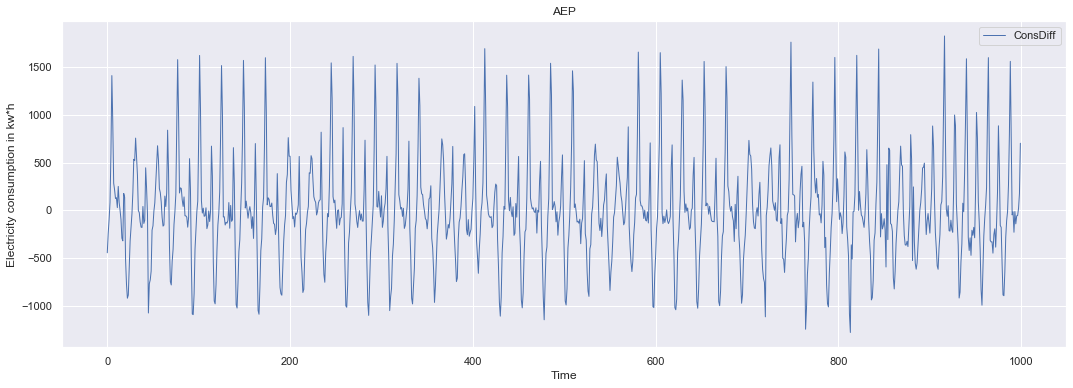

In [27]:
#TODO: use this data for prediction, for more accurate measurment. 
CreatePlotTotalConsumption(df=dfDiff.iloc[:1000,], y_col='ConsDiff', chart_title='AEP', 
                               x_label='Time', y_label='Electricity consumption in kw*h')

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

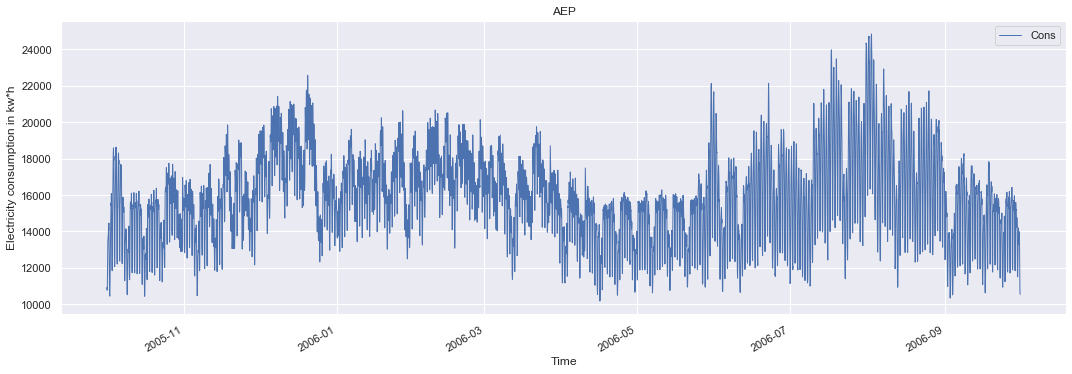

In [28]:
 CreatePlotTotalConsumption(df=dfAEP.iloc[24*365:2*24*365,:], y_col='Cons', chart_title='AEP', 
                               x_label='Time', y_label='Electricity consumption in kw*h')